<a href="https://colab.research.google.com/github/MdylanM/THesis/blob/main/best_model_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import itertools
import multiprocessing.pool
import threading
from functools import partial
from matplotlib import pyplot as plt

from keras.applications.vgg16 import VGG16

import keras
import pandas as pd
from keras import backend as K
from keras import layers, models
from keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D
from keras.backend import relu, sigmoid
from keras.utils import np_utils
from keras.models import Model
import numpy as np
import statistics
import time

from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

import tensorflow as tf
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.contrib.session_bundle import exporter
import os


Using TensorFlow backend.


In [ ]:
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"

--2020-01-13 17:04:43--  https://www.win.tue.nl/~cdecampos/trainDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203493642 (194M) [text/plain]
Saving to: ‘trainDataSmall.npz’

trainDataSmall.npz  100%[===================>] 194.07M  30.5MB/s    in 13s     

2020-01-13 17:04:57 (15.2 MB/s) - ‘trainDataSmall.npz’ saved [203493642/203493642]

--2020-01-13 17:04:58--  https://www.win.tue.nl/~cdecampos/testDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101034899 (96M) [text/plain]
Saving to: ‘testDataSmall.npz’

testDataSmall.npz   100%[===================>]  96.35M  19.5MB/s    in 11s     

2020-01-13 17:05:09 (8.82 MB/s) - ‘testDataSmall.npz’ saved [101034899/101034899]



In [ ]:
data = np.load("testDataSmall.npz")
X_test = AdjustBrightness(data["X_test"])
Y_test = change_label(data["Y_test"])

In [ ]:

data = np.load("trainDataSmall.npz",)

def calculatemeanTotal(ArrayFile):
    meangreyscale = []
    for i in range(0, ArrayFile.shape[0]):
        mean = sum(ArrayFile[i].ravel())/len(ArrayFile[i].ravel())
        meangreyscale.append(mean)
    return statistics.mean(meangreyscale)

def AdjustBrightness(ArrayFile3D):
    Mean = calculatemean(ArrayFile3D)
    lst = []
    for i in range(0, ArrayFile3D.shape[0]):
        ravelledimage = ArrayFile3D[i].ravel()
        factor = Mean / (sum(ravelledimage)/len(ravelledimage))
        adjusted = [x*factor for x in ravelledimage]
        lst.append(np.asarray(adjusted))
    return np.asarray(lst).reshape(ArrayFile3D.shape[0],128,128,3)

def calculatemean(ArrayFile):
    meangreyscale = []
    for i in range(0, ArrayFile.shape[0]):
        mean = sum(ArrayFile[i].ravel())/len(ArrayFile[i].ravel())
        meangreyscale.append(mean)
    return statistics.mean(meangreyscale)
def change_label(data):
  changed = list()
  for array in data:
      for i in range(0, 4):
          if array[i] == 1:
              if i == 0:
                  new = np.array([1., 0., 0.])
              elif i == 1:
                  new = np.array([0., 1., 0.])
              elif i == 2:
                  new = np.array([0., 1., 0.])
              elif i == 3:
                  new = np.array([0., 0., 1.])
              elif i == 4:
                  new = np.array([0., 0., 1.])
      changed.append(new)
  return np.array(changed)


X_train = AdjustBrightness(data["X_train"])
Y_train = change_label(data["Y_train"])




In [ ]:
base_model = ResNet50(input_shape= (128, 128, 3), include_top=False,weights='imagenet')
x = base_model.output
x= Flatten(name='flatten')(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation= 'softmax')(x)

model= Model(inputs = base_model.input, outputs = predictions)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])


In [ ]:
t=time.time()
hist = model.fit(X_train, Y_train, batch_size=200, epochs=8, verbose=1, validation_data=(X_test, Y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=200, verbose=1)


Train on 5000 samples, validate on 2500 samples
Epoch 1/8
5000/5000 [==============================] - 20s 4ms/step - loss: 1.2462 - acc: 0.4194 - val_loss: 0.9847 - val_acc: 0.5580
Epoch 2/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.9877 - acc: 0.5038 - val_loss: 0.8737 - val_acc: 0.6096
Epoch 3/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.9090 - acc: 0.5532 - val_loss: 0.8240 - val_acc: 0.6388
Epoch 4/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.8465 - acc: 0.5964 - val_loss: 0.7876 - val_acc: 0.6404
Epoch 5/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.7817 - acc: 0.6334 - val_loss: 0.7581 - val_acc: 0.6524
Epoch 6/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.7307 - acc: 0.6626 - val_loss: 0.7792 - val_acc: 0.6484
Epoch 7/8
5000/5000 [==============================] - 13s 3ms/step - loss: 0.6807 - acc: 0.6838 - val_loss: 0.7509 - val_acc: 0.6568
Epoch 8/8
5000

In [ ]:
# Keras Error Reset
from keras import backend as K

K.clear_session()

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(8)

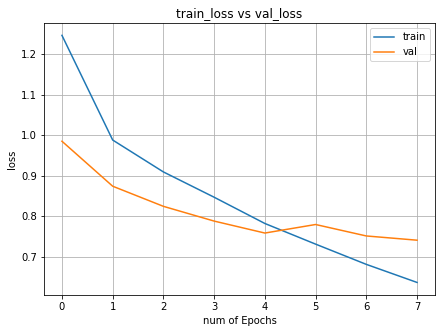

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


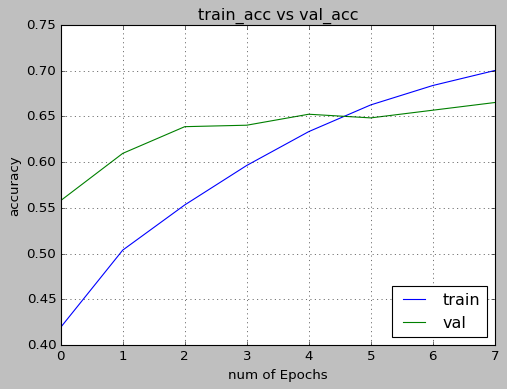

In [ ]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
model.save("Retinopathy.model.hdf5")